# Project 3: Web APIs & Classification

**Preprocessing and Modeling**

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import nltk

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

Import data

In [2]:
df = pd.read_csv('./c_onion.csv')
df.head()

,subreddit,title,title_len,tokens,filtered_tokens,clean_tokens,lemma_words,clean_text
0,1,Surgeon Kind Of Pissed Patient Seeing Her Defo...,109,"['surgeon', 'kind', 'of', 'pissed', 'patient',...","['surgeon', 'kind', 'pissed', 'patient', 'seei...","['surgeon', 'kind', 'pissed', 'patient', 'seei...","['surgeon', 'kind', 'pissed', 'patient', 'seei...",surgeon kind pissed patient seeing deformed fa...
1,1,McDonald’s blocked from building drive-through...,83,"['mcdonald’s', 'blocked', 'from', 'building', ...","['mcdonald’s', 'blocked', 'from', 'building', ...","['mcdonald’s', 'blocked', 'building', 'drive-t...","['mcdonald’s', 'blocked', 'building', 'drive-t...",mcdonald’s blocked building drive-through rome...
2,1,Gwyneth Paltrow Touts New Diamond-Encrusted Tr...,89,"['gwyneth', 'paltrow', 'touts', 'new', 'diamon...","['gwyneth', 'paltrow', 'touts', 'diamond-encru...","['gwyneth', 'paltrow', 'touts', 'diamond-encru...","['gwyneth', 'paltrow', 'tout', 'diamond-encrus...",gwyneth paltrow tout diamond-encrusted trepana...
3,1,Artist Crafting Music Box Hopes It Delights At...,81,"['artist', 'crafting', 'music', 'box', 'hopes'...","['artist', 'crafting', 'music', 'hopes', 'deli...","['artist', 'crafting', 'music', 'hopes', 'deli...","['artist', 'crafting', 'music', 'hope', 'delig...",artist crafting music hope delight least child...
4,1,Homeowner Trying To Smoke Out Snakes Accidenta...,66,"['homeowner', 'trying', 'to', 'smoke', 'out', ...","['homeowner', 'trying', 'smoke', 'snakes', 'ac...","['homeowner', 'trying', 'smoke', 'snakes', 'ac...","['homeowner', 'trying', 'smoke', 'snake', 'acc...",homeowner trying smoke snake accidentally burn...


In [3]:
df.tail()

,subreddit,title,title_len,tokens,filtered_tokens,clean_tokens,lemma_words,clean_text
4239,0,"Stress, not fun, cited as a major reason to co...",83,"['stress,', 'not', 'fun,', 'cited', 'as', 'a',...","['stress,', 'fun,', 'cited', 'major', 'reason'...","['stress,', 'fun,', 'cited', 'major', 'reason'...","['stress,', 'fun,', 'cited', 'major', 'reason'...","stress, fun, cited major reason consume cannab..."
4240,0,Gov. Ron DeSantis (R-FL) quotes MLK while intr...,101,"['gov.', 'ron', 'desantis', '(r-fl)', 'quotes'...","['gov.', 'desantis', '(r-fl)', 'quotes', 'whil...","['gov.', 'desantis', '(r-fl)', 'quotes', 'intr...","['gov.', 'desantis', '(r-fl)', 'quote', 'intro...",gov. desantis (r-fl) quote introducing “stop w...
4241,0,Gov. Ron DeSantis quotes MLK while introducing...,94,"['gov.', 'ron', 'desantis', 'quotes', 'mlk', '...","['gov.', 'desantis', 'quotes', 'while', 'intro...","['gov.', 'desantis', 'quotes', 'introducing', ...","['gov.', 'desantis', 'quote', 'introducing', '...",gov. desantis quote introducing “stop woke act...
4242,0,A scientist who taught rats how to play Doom I...,76,"['a', 'scientist', 'who', 'taught', 'rats', 'h...","['scientist', 'taught', 'rats', 'play', 'doom'...","['scientist', 'taught', 'rats', 'play', 'doom'...","['scientist', 'taught', 'rat', 'play', 'doom',...",scientist taught rat play doom want stream twitch
4243,0,"Italian antivax health worker who said ""i hope...",131,"['italian', 'antivax', 'health', 'worker', 'wh...","['italian', 'antivax', 'health', 'worker', 'sa...","['italian', 'antivax', 'health', 'worker', 'sa...","['italian', 'antivax', 'health', 'worker', 'sa...","italian antivax health worker said hope covid""..."


In [4]:
df.shape

(4244, 8)

**Baseline Score**

Here I conduct model-prep and use Pipeline and GridSearch to determine the most optimal model to run my data on.

In [5]:
x = df['subreddit'].value_counts(normalize = True)
x

1    0.547597
0    0.452403
Name: subreddit, dtype: float64

baseline set at 54%,thus my model must be better than 54%, if not,  I know the model is not performing well.

In [6]:
from wordcloud import WordCloud
from PIL import Image

In [7]:
def show_wordcloud(data, title):
    wordcloud = WordCloud(
       background_color='white',
       max_words=200,
       colormap='RdBu',
       scale=3).generate(str(data))
    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=15)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

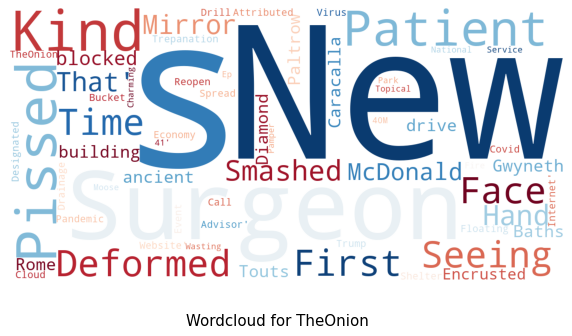

In [8]:
show_wordcloud(df[df["subreddit"]==1].title.values,'Wordcloud for TheOnion')

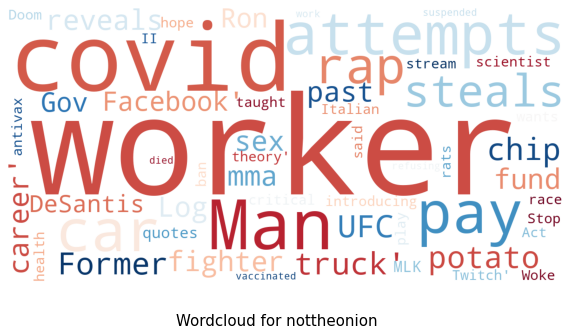

In [9]:
show_wordcloud(df[df["subreddit"]==0].title.values,'Wordcloud for nottheonion')

Model prep: Create X and y variables

In [10]:
X = df['title']
y = df['subreddit']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)





In [12]:
y_train

4198    0
1338    1
1513    1
1524    1
2532    0
       ..
3104    0
599     1
1412    1
3694    0
117     1
Name: subreddit, Length: 3183, dtype: int64

Model 1:CountVectorizer & Logistic Regression 

In [13]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

In [14]:
# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english'],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.7750549795790135
Train score 0.9987433239082626
Test score 0.763430725730443


{'cvec__ngram_range': (1, 3), 'cvec__stop_words': None, 'lr__C': 1}

Model 2: TfidfVectorize & Logistic Regression

In [15]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.763430725730443
Train score 0.9274269557021678
Test score 0.767200754005655


{'lr__C': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 2,
 'tvect__ngram_range': (1, 2)}

This model is also overfit. However, Model 1 is better performed with a better test score.

Model 3: CountVectorizer & MultinomialNB (Best Score)

In [16]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.7841658812441094
Train score 0.9971724787935909
Test score 0.7785108388312912


{'cvec__ngram_range': (1, 3), 'nb__alpha': 0.6}

The model is overfit, I am optimizing for accuracy. I want to ensure that all predictions are correct. when all posts can be classified to the indivual two subreddits accordingly.

Model 4: TfidfVectorizer & MultinomialNB

In [17]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.753697560301334
Train score 0.8846999685830977
Test score 0.7483506126295947


{'nb__alpha': 0.1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 4,
 'tvect__ngram_range': (1, 2)}

So the test score is not as good as Model 3 CountVectorizer & MultinomialNB

**Best Models**

CountVectorizer & MultinomialNB, will be used to convey a confusion matrix which will show all evaluation scores.

In [18]:
#Instantiate 
nb = MultinomialNB(alpha = 0.36)
cvec = CountVectorizer(ngram_range= (1, 3))

# Fit and transform 
cvec.fit(X_train)

Xcvec_train = cvec.transform(X_train)
Xcvec_test = cvec.transform(X_test)

# Fit classifier
nb.fit(Xcvec_train,y_train)

# Create predictions for Y training data
pred = nb.predict(Xcvec_test)

print(nb.score(Xcvec_test, y_test))

0.7785108388312912


**Confusion Matrix**

In [20]:
# Create a confusion matrix
cf_matrix = metrics.confusion_matrix(y_test, pred)
cf_matrix

array([[345, 135],
       [100, 481]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

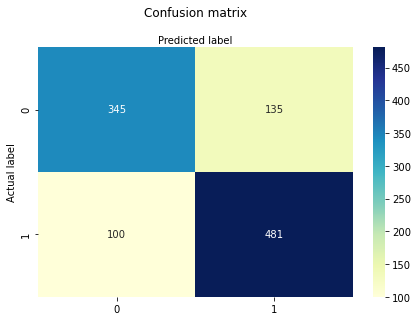

In [23]:
# name  of classes
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# heatmap
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [24]:
# Assign True -, False +, False -, True + variables
cf_matrix = np.array(cf_matrix).tolist()

tneg_fp, fn_tp = cf_matrix

tneg, fp = tneg_fp
fn, tp = fn_tp

In [28]:
# Print Scores 
print("Accuracy:",round(metrics.accuracy_score(y_test, pred)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_test, pred)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_test, pred)*100, 2), '%')
print("Specificity:", round((tneg/(tneg+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tneg+fp+fn+tneg)*100, 2), '%')

Accuracy: 77.85 %
Precision: 78.08 %
Recall: 82.79 %
Specificity: 71.88 %
Misclassification Rate: 25.41 %


CountVectorizer & Logistic Regression: Best Coefficient Interpretability

In [29]:
#Instantiate 
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec2 = CountVectorizer()

# Fit and transform 
cvec2.fit(X_train)

Xcvec2_train = cvec2.transform(X_train)
Xcvec2_test = cvec2.transform(X_test)

# Fit classifier
lr.fit(Xcvec2_train,y_train)

# Create the predictions for Y training data
lr_preds = lr.predict(Xcvec2_test)

print(lr.score(Xcvec2_test, y_test))

0.765315739868049


Coefficient Analysis

In [30]:
# Create list of logistic regression coef
lr_coef = np.array(lr.coef_).tolist()
lr_coef = lr_coef[0]

# create dataframe using lasso coef
lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
cvec2.get_feature_names(), columns = ["penalized_regression_coefficients"])

# sort values from high to low
lr_coef = lr_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)


# create best and worst performing lasso coef
df_head = lr_coef.head(5)
df_tail = lr_coef.tail(5)


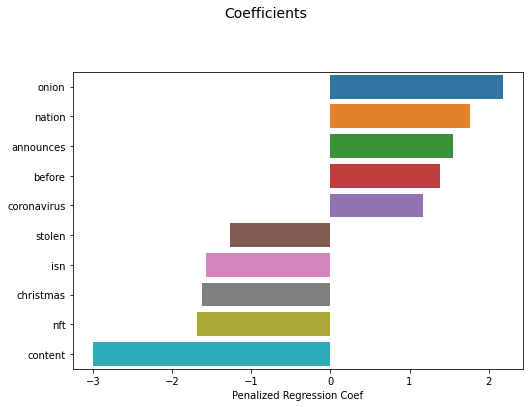

In [35]:
# merge them back
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficients', size=14)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_merged.index, 
data=df_merged)
ax.set(xlabel='Penalized Regression Coef')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [38]:
print("The word that contributes the most positively from r/TheOnion is", 
      df_merged.index[0], "followed by", 
      df_merged.index[1], "and",
      df_merged.index[2],".")

print("The word that contributes the most positively from r/nottheonion is", 
      df_merged.index[-1], "followed by", 
      df_merged.index[-2], "and",
      df_merged.index[-3],".")

The word that contributes the most positively from r/TheOnion is onion followed by nation and announces .
The word that contributes the most positively from r/nottheonion is content followed by nft and christmas .


In [39]:
# Show coefficients that affect r/TheOnion
df_merged_head = df_merged.head(10)
exp = df_merged_head['penalized_regression_coefficients'].apply(lambda x: np.exp(x))
df_merged_head.insert(1, 'exp', exp)
df_merged_head.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
onion,2.179,8.837464
nation,1.763,5.829901
announces,1.550,4.711470
before,1.389,4.010837
coronavirus,1.165,3.205923
stolen,-1.274,0.279711
isn,-1.578,0.206387
christmas,-1.625,0.196912
nft,-1.691,0.184335
content,-3.003,0.049638


In [40]:
print("As occurences of", df_merged_head.index[0], "increase by 1 in a title, that title is", 
      round(df_merged_head['exp'][0],2), "times as likely to be classified as r/TheOnion.")

As occurences of onion increase by 1 in a title, that title is 8.84 times as likely to be classified as r/TheOnion.


In [41]:
# Show coefficients that affect r/nottheonion
df_merged_tail = df_merged.tail(10)
exp = df_merged_tail['penalized_regression_coefficients'].apply(lambda x: np.exp(x * -1))
df_merged_tail.insert(1, 'exp', exp)
df_merged_tail.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
content,-3.003,20.145884
nft,-1.691,5.424903
christmas,-1.625,5.078419
isn,-1.578,4.845256
stolen,-1.274,3.575124
coronavirus,1.165,0.311923
before,1.389,0.249325
announces,1.550,0.212248
nation,1.763,0.171530
onion,2.179,0.113155


In [42]:
print("As occurences of", df_merged_tail.index[-1], "increase by 1 in a title, that title is", 
      round(df_merged_tail['exp'][-1],2), "times as likely to be classified as r/nottheonion.")

As occurences of content increase by 1 in a title, that title is 20.15 times as likely to be classified as r/nottheonion.


**Conclusions and Next-Steps**

The most model to optimize for accuracy in detecting fake news and absurd news uses CountVectorizer and MultinomialDB. The optimal parameters for this model are where ngram_range = (1,3) and alpha = 0.36.

    Accuracy: 77.85 %
    Precision: 78.08 %
    Recall: 82.79 %
    Specificity: 71.88 %
    Misclassification Rate: 25.41 %
   

To interpret my coefficients, I used my CountVectorizer & Logistic Regression model.

    The word that contributes the most positively to being from r/TheOnion is 'incredible' followed by 'questions' and 'heartbreaking'.
        As occurences of "incredible" increase by 1 in a title, that title is 10.32 times as likely to be classified as r/TheOnion.

    The word that contributes the most positively to being from r/nottheonion is 'australia' followed by 'title' and 'florida'.
        As occurences of "australia" increase by 1 in a title, that title is 15.03 times as likely to be classified as r/nottheonion.

Natural Language Processing of text is one way to analyze fake news, but a major gap exists: image & video analysis. For my next-steps, I am interested in being able to interpret media (images and videos) and classify them as authentic news, fake news, or none of the above (i.e., media for entertainment).
